## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import manifold
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import NullFormatter
from sklearn.neighbors import NearestNeighbors
from time import time
from scipy.cluster.hierarchy import dendrogram, linkage
from collections import OrderedDict
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
fname, fnamey = "data/x_12d.dat", "data/y_12d.dat"
data=np.loadtxt(fname, delimiter='\t')
y=np.loadtxt(fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

N= 600   L=D= 12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

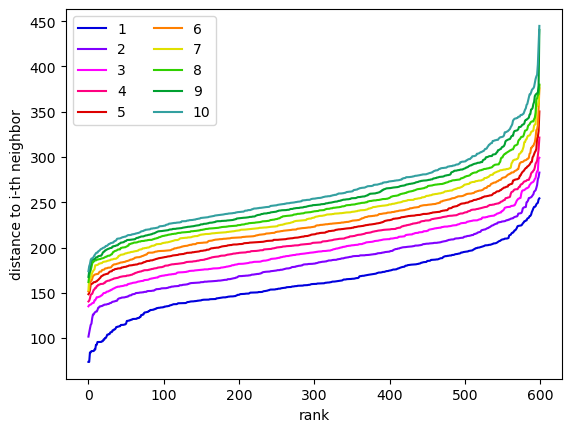

mean minimum distance between points:  162.34622464324366


In [3]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)

## t-SNE visualization, for true labels

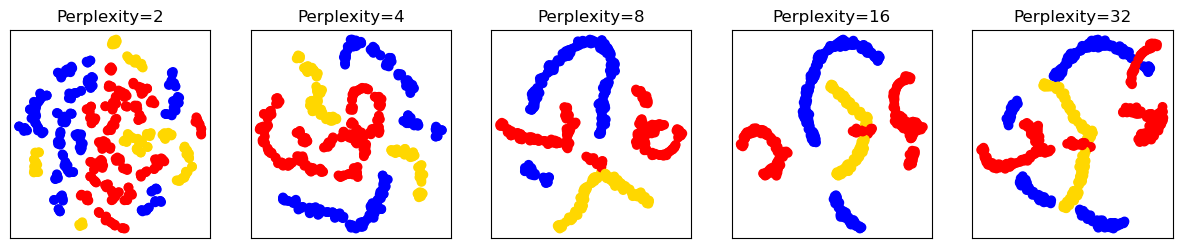

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

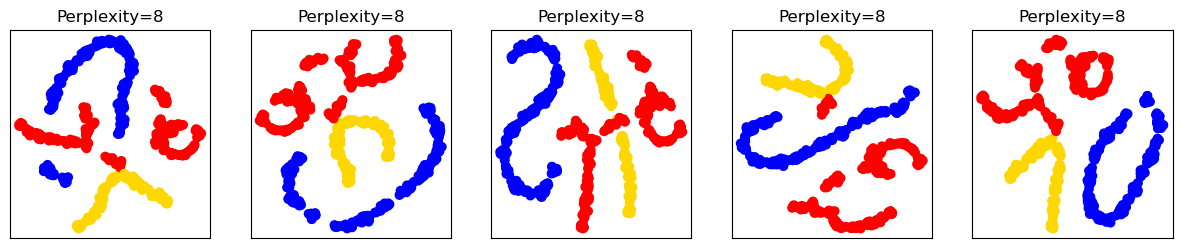

In [5]:
n_samples = N
n_components = 2 
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',random_state=i, 
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

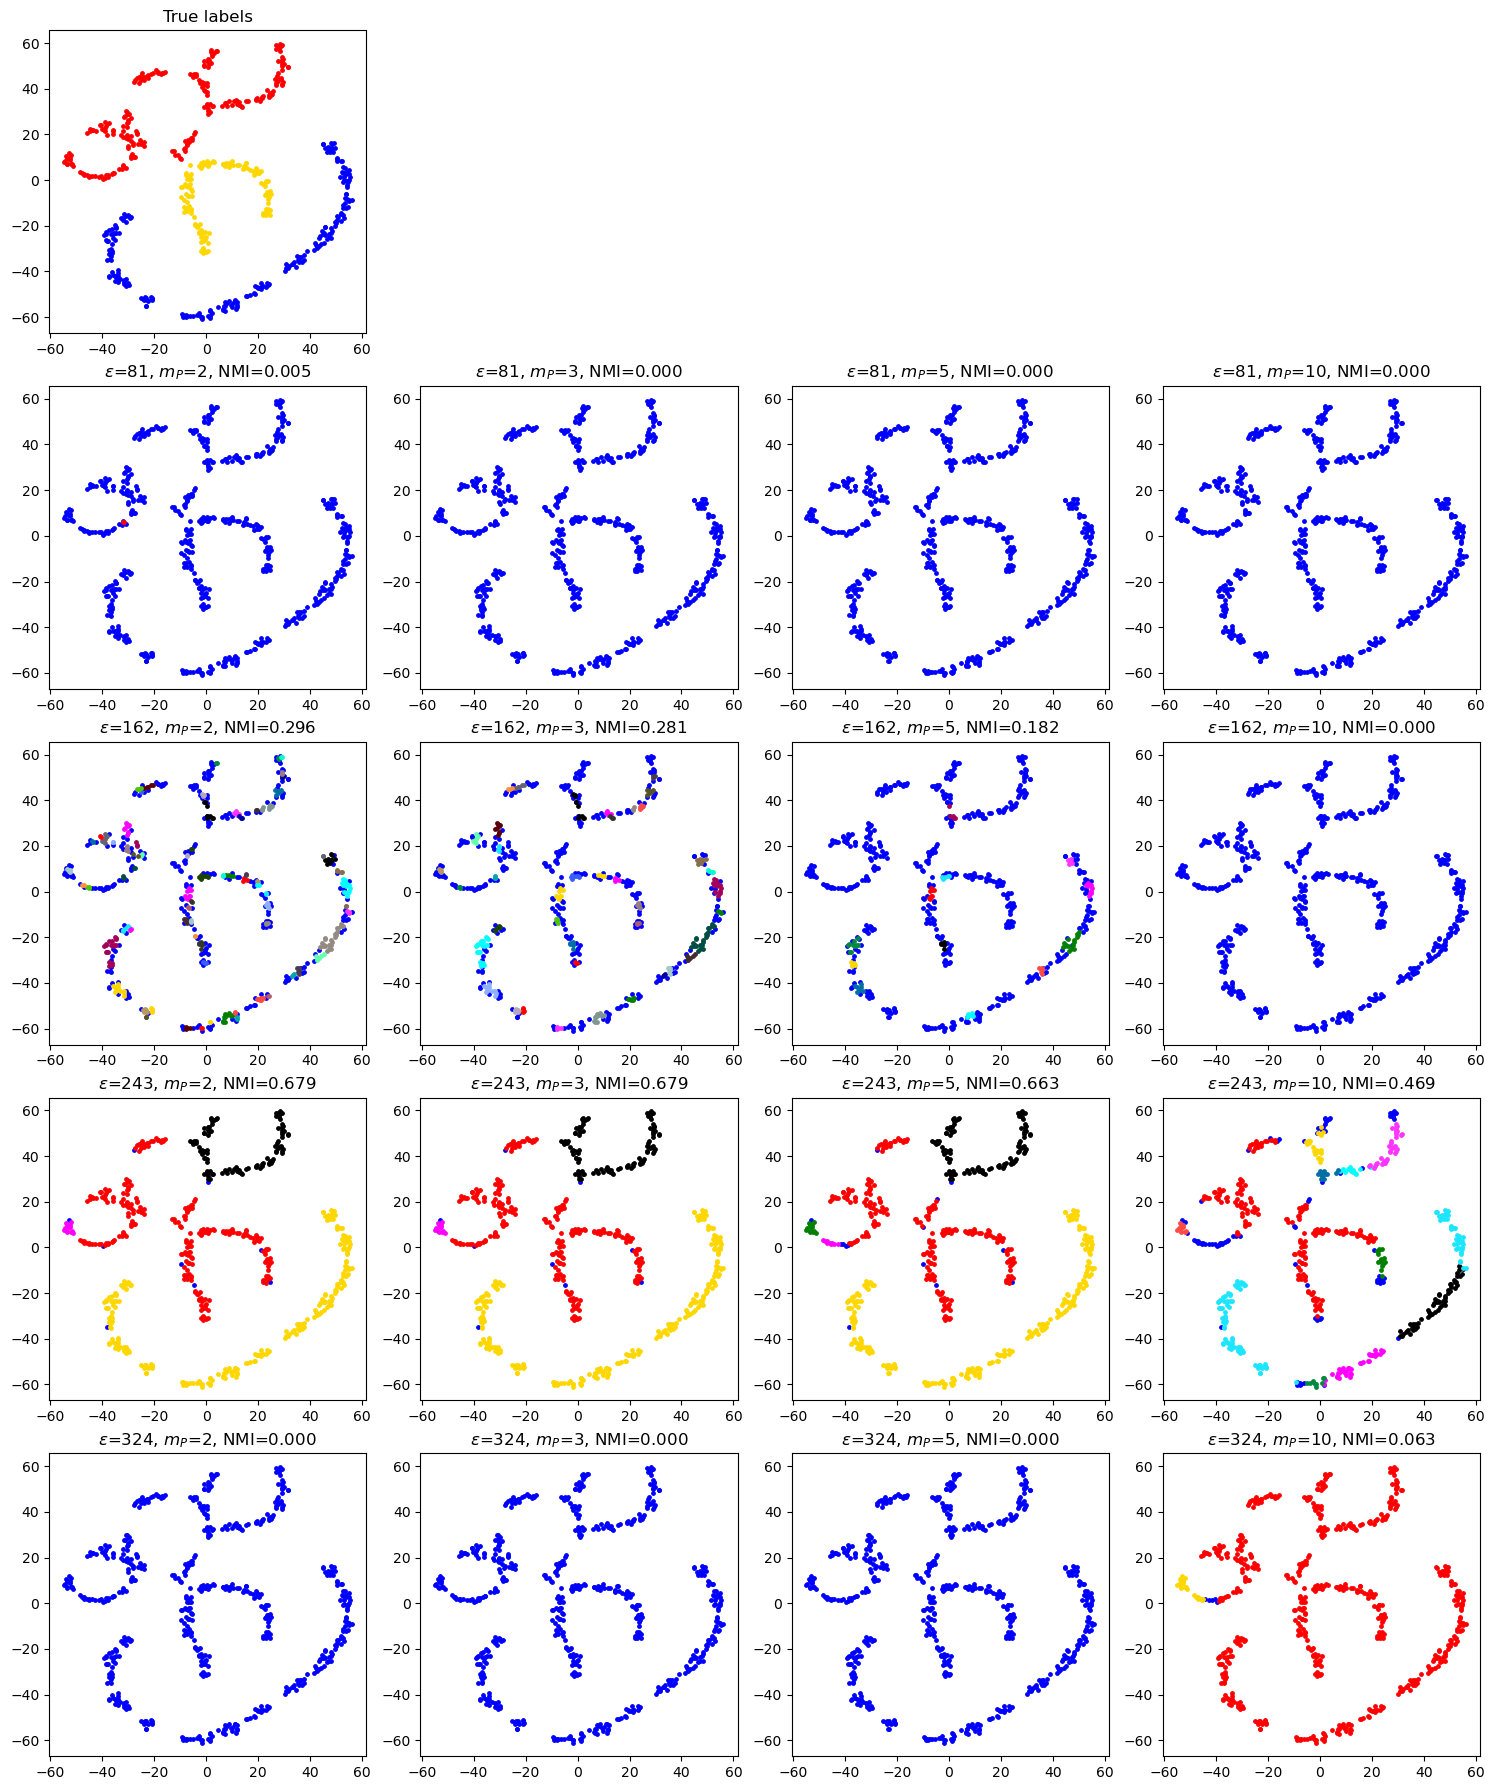

In [6]:
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r,1.5*r,2*r]

min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(15,18))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()


HOMEWORK

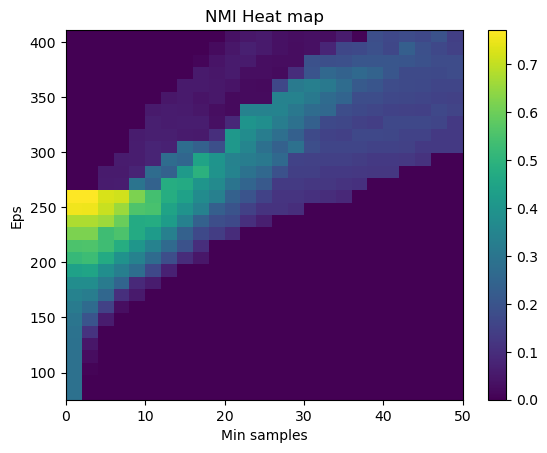

In [7]:
eps_range=np.linspace(r/2,2.5*r,30)
min_sample_range = np.arange(1,50,2, dtype=int)

XX,YY=np.meshgrid(min_sample_range, eps_range)

DIMY=len(eps_range)
DIMX=len(min_sample_range)
it=0

nmi=np.zeros((DIMY,DIMX))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi[i,j]=NMI(y_hat, y_true)
        

plt.pcolormesh(XX,YY,nmi)
plt.xlabel('Min samples')
plt.ylabel('Eps')
plt.title('NMI Heat map')
plt.colorbar()
plt.show()

In [8]:
data = np.loadtxt("data/x_12d.dat", delimiter='\t')
y = np.loadtxt("data/y_12d.dat", dtype=int)
colors = ['r', 'b', 'gold']

scaler = StandardScaler()
X = scaler.fit_transform(data)

pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)
X_pca_2d = pca_2d.fit_transform(X)
X_pca_3d = pca_3d.fit_transform(X)

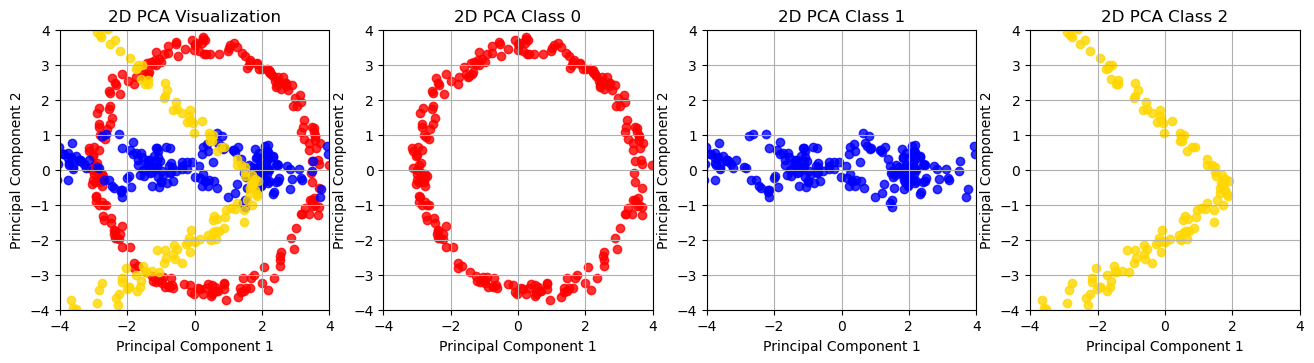

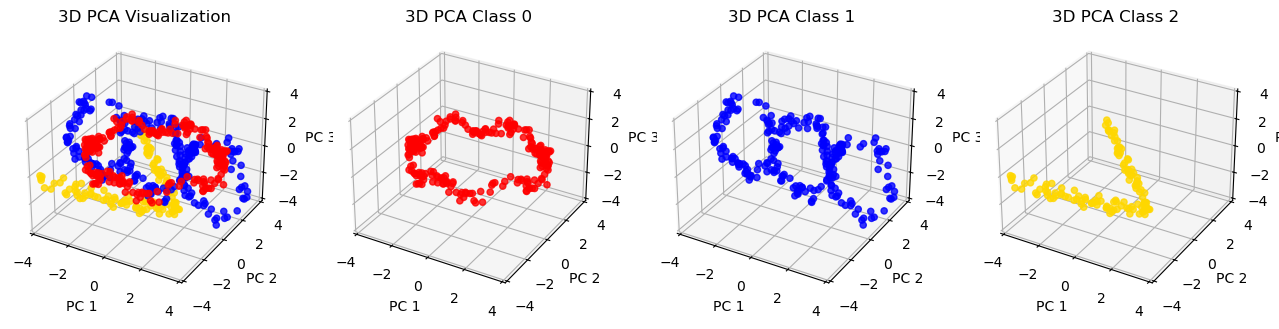

Explained variance ratio for 2D PCA: [0.4763583  0.31041612]
Explained variance ratio for 3D PCA: [0.4763583  0.31041612 0.15690151]


In [9]:
fig = plt.figure(figsize=(16, 8))
unique_labels = np.unique(y)

ax1 = fig.add_subplot(2, 4, 1)
for i, color in zip(unique_labels, colors):
    ax1.scatter(X_pca_2d[y == i, 0], X_pca_2d[y == i, 1], c=color, alpha=0.8, label=f'Class {i}')
ax1.set_title('2D PCA Visualization')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.grid(True)
ax1.set_xlim([-4, 4])
ax1.set_ylim([-4, 4])

for index, label in enumerate(unique_labels):
    ax = fig.add_subplot(2, 4, index + 2)
    ax.scatter(X_pca_2d[y == label, 0], X_pca_2d[y == label, 1], c=colors[index], alpha=0.8, label=f'Class {label}')
    ax.set_title(f'2D PCA Class {label}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.grid(True)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

fig_3d = plt.figure(figsize=(16, 8))

ax2 = fig_3d.add_subplot(2, 4, 1, projection='3d')
for i, color in zip(unique_labels, colors):
    ax2.scatter(X_pca_3d[y == i, 0], X_pca_3d[y == i, 1], X_pca_3d[y == i, 2], c=color, alpha=0.8, label=f'Class {i}')
ax2.set_title('3D PCA Visualization')
ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 2')
ax2.set_zlabel('PC 3')
ax2.grid(True)
ax2.set_xlim([-4, 4])
ax2.set_ylim([-4, 4])
ax2.set_zlim([-4, 4])

for index, label in enumerate(unique_labels):
    ax = fig_3d.add_subplot(2, 4, index + 2, projection='3d')
    ax.scatter(X_pca_3d[y == label, 0], X_pca_3d[y == label, 1], X_pca_3d[y == label, 2], c=colors[index], alpha=0.8, label=f'Class {label}')
    ax.set_title(f'3D PCA Class {label}')
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.grid(True)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([-4, 4])

plt.show()

print("Explained variance ratio for 2D PCA:", pca_2d.explained_variance_ratio_)
print("Explained variance ratio for 3D PCA:", pca_3d.explained_variance_ratio_)

/home/alcadis/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


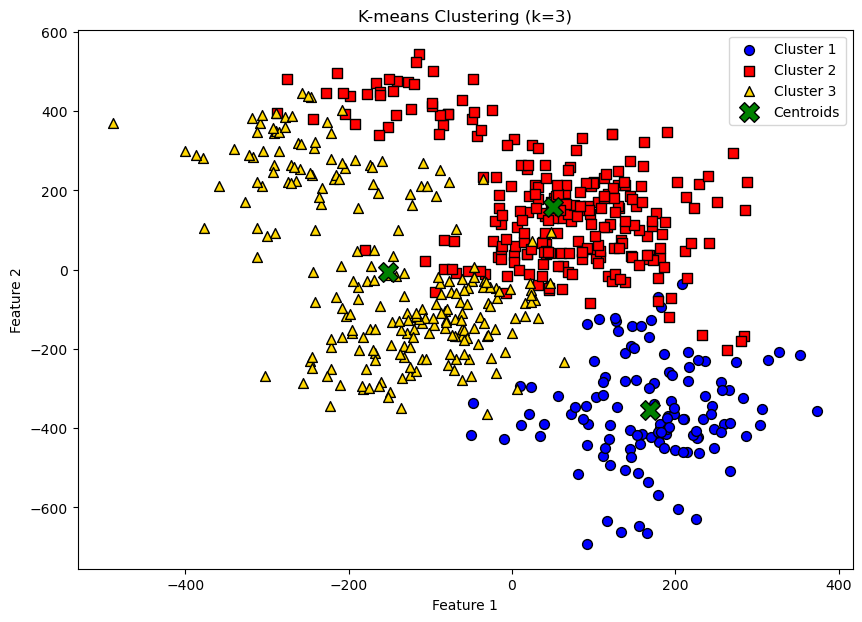

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
labels = kmeans.predict(data)

markers = ['o', 's', '^']
colors = ['blue', 'red', 'gold']

plt.figure(figsize=(10, 7))
for i in range(k):
    plt.scatter(data[labels == i, 0], data[labels == i, 1], s=50, c=colors[i], marker=markers[i], edgecolor='k', label=f'Cluster {i+1}')

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c="green", s=200, marker='X', edgecolor='k', label='Centroids')
plt.title("K-means Clustering (k=3)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

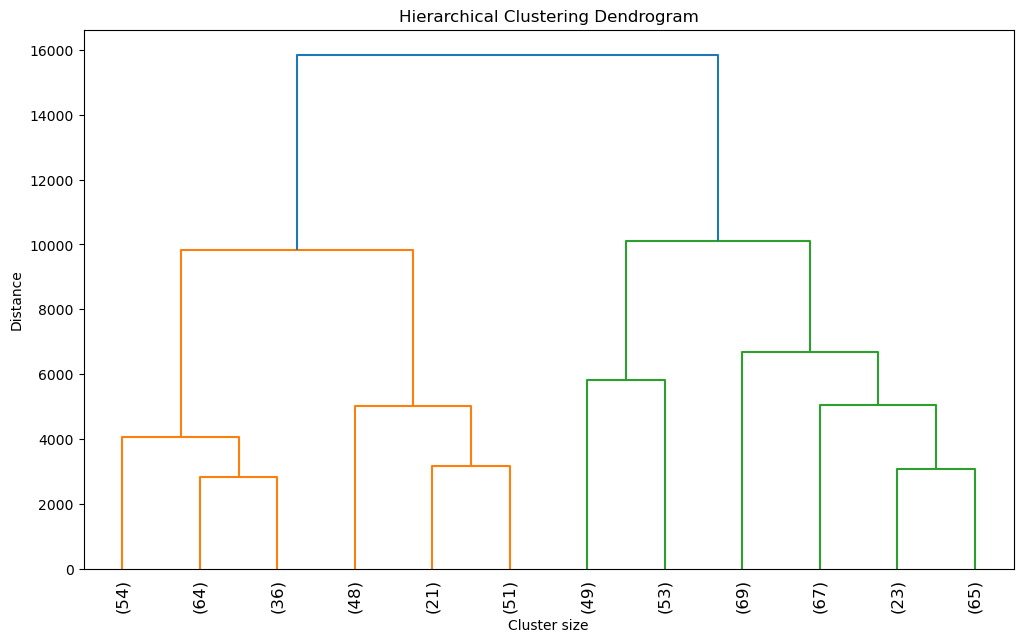

In [11]:
Z = linkage(data, 'ward')

plt.figure(figsize=(12, 7))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90., 
    leaf_font_size=12.,
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()